# Building a simple Content-Based Recommender System for Netflix Movies and TV Shows

### Objective
With over 6000 movie and tv shows in a sample dataset, there is an overwhelming number of entertainment options available to Netflix users. As such, the purpose of this project aims to make a TV show / movie recommendation using a simple content based recommender system. We would take in an input which is a user's personal favourite show/movies and pick up the top 10 films that are most similar to the personal favourite. Here, we explore 2 possible ways to identify similar items: (1) a simple similarity measure - Cosine Similarity (2) Clustering Algorithm - Latent Dirichlet Allocation (LDA).

### Basics on Recommender System
Recommender Systems can be generally divided into 2 categories: Collaborative Filtering System and Content-based Recommender System. A Collaborative Filtering recommends an item that other users of similar characteristics have liked in the past. A content-based recommender system recommends an item which are similar to the ones the user has liked in the past. Since the given dataset only contains item data, we would focus on creating a basic content-based recommender system. 

### Basics on Text Similarity

There are various text similarity metrics and one of the popular metrics is Cosine Similarity. 
Consine Similarity measures the similarity between 2 documents by measuring the consine of angle between two vectors. Here's a simple example to illustrate the calculation of cosine similarity:



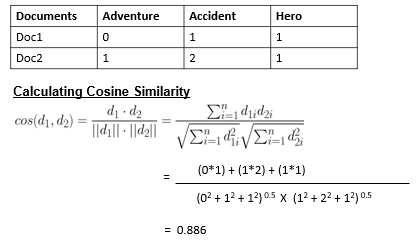

### Basics on Topic Modelling
Topic Modelling is an unsupervised learning technique which groups documents based on the content similarity. One popular algorithm is Latent Dirichlet Allocation (LDA). In LDA, each topic is a probability distribution of words and each document is a probability distribution of topics. The more similar the documents are, the closer they are to each other in the multi-dimensional vector space, thus forming clusters. 




### References
https://www.cse.iitk.ac.in/users/nsrivast/HCC/Recommender_systems_handbook.pdf

https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243


### 1. Cosine Similarity

Cosine similarity is computed based on the features - 'title', 'type', 'listed_in', 'director', 'cast', 'rating' and 'description'.

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")
df.head()

#### 1.1 Data Pre-Processing

In [ ]:
cols = ['title', 'type', 'listed_in', 'director', 'cast', 'rating', 'description']
df['combined'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
df['combined'] = df['combined'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

#### 1.2 Creating Document Vectors

In [ ]:
documents = df['combined']

# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english') # convert all words to lowercase and remove stop words
sparse_matrix = count_vectorizer.fit_transform(documents)

# Convert Sparse Matrix to Pandas Dataframe 
doc_term_matrix = sparse_matrix.todense()
matrix_df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), index=df.index)


#### 1.3 Computing Cosine Similarity between each document

In [ ]:
similarity_scores = cosine_similarity(sparse_matrix, sparse_matrix) 

scores_df = pd.DataFrame(similarity_scores )
scores_df

#### 1.4 Top 10 recommended tv shows/movies based on Cosine Similarity

In [ ]:
def recommend(title,scores_df, df):
    recommended = []
    
    # getting title's index 
    title = title.lower()
    df['title'] = df['title'].str.lower()
    index = df[df['title']==title].index[0]
    
    top10_list = list(scores_df.iloc[index].sort_values(ascending = False).iloc[1:11].index)
    
    
    for each in top10_list:
        recommended.append(df.iloc[each].title)
    
    return recommended
    
    

In [ ]:
recommend('Avengers: Infinity War',scores_df, df)

In [ ]:
recommend('Naruto Shippuden : Blood Prison',scores_df, df)

### 2. Topic Modelling with LDA

I have chosen to explore the use of LDA on the 'description' textual data to detect similar documents because I speculate that there might be previously unknown underlying topics in the movie/tv shows' storyline which differs from the typical genre classification such as Adventure, Romance.  

In [ ]:
# Importing modules
import pandas as pd
import os
import re

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

# Visualize the topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis



In [ ]:
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")
df.head()

#### 2.1 Data Pre-Processing

In [ ]:
# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
df['description'] = df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(df['description']))

# print(data_words)

In [ ]:
stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [ ]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

In [ ]:
# spotted bigrams such as high_school, civil_war, martial_arts
print(data_words_bigrams)

#### 2.2 EDA

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])
# print(id2word[:10])

In [ ]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()


#### 2.3 Hyperparameter Tuning for LDA Model

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [0,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

In [ ]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()



#### 2.4 Final LDA Model

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [ ]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [ ]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

#### 2.5 Visualize Topics

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

#### 2.6  Top 10 recommended tv shows/movies based on topic modelling

In [ ]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended


In [ ]:
recommend_by_storyline("Avengers: Infinity War", df)

In [ ]:
recommend_by_storyline("Naruto Shippuden : Blood Prison", df)